### Algorithm overview

- Compute distance between each pair of in-nodes and out-nodes (geodesic distance on globe, later "distance" can be modified to include trade barriers, etc.)
- Probability of edge between (u,v) is proportional to in(u) * in(v) / dist(u,v)
- Connect nodes and assign weights according to iterative proportional fitting
- TODO: Validation:
    - For each country i:
        pred_exp = sum(outflows from grid cells in i that are international edges)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Gravity Model...
Edges after gravity calculation: 6638831
Gravity Model Complete. Ensemble Generated.
Running IPF...
Initial edges in ensemble: 6638831
IPF converged in 30 iterations
IPF complete. Flow matrix generated with 6638831 edges.
🌍 Grid Dataset Summary
  NetCDF Source: unknown
  Time Selected: 2000
  Inflow Var: prod_inflow (tonnes Fe per grid)
  Outflow Var: prod_outflow (tonnes Fe per grid)
  Total Flow (IO): 670,220,737.12 670,220,737.12

📊 Ensemble Graph
  Shape: (474, 14007)
  Total Weight: 143,036,510,409,253.22
  Nonzero Edges: 6638831

📦 Flow Graph
  Shape: (474, 14007)
  Total Flow: 670,220,737.12
  Nonzero Edges: 6638831


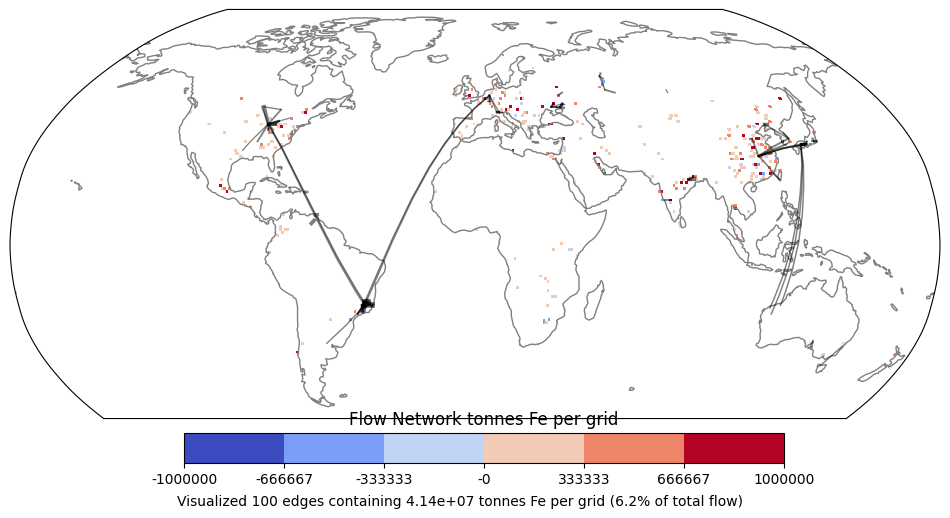

In [21]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
from FlowNetwork import FlowNetwork
import os

# Initialize the flow network with NetCDF data and variable names
grid_data_path = os.path.join('data', 'L.T.iron_flows.2000-2016.a.nc')
fn = FlowNetwork(grid_data_path, 'prod_outflow', 'prod_inflow', time='2000')

# Generate the ensemble using the gravity model
fn.gravity_model()

# Sample the actual flow network using IPF
fn.ipf_flows()

# Integrate imports and exports over each country
# fn.compute_country_trade() # This takes forever because of how country_fraction_ds is implemented, so I run it in a script.

# Print summary of the network
print(fn)
fn.plot_network_map(edge_thickness=5, num_edges=100, vmin=-1e6, vmax=1e6, edge_color='black')

In [22]:
### TESTS ###

fn.check_mass_conservation()
# coord = (-33.5, 139.5)
# i = fn.coord_to_index(coord)

# print(fn.df.loc[coord])
# print(fn.flow[:, i].sum())

Checking mass conservation...
✅ All nodes pass mass conservation check.


In [ ]:
%load_ext autoreload
%autoreload 2

from FlowNetwork import FlowNetwork
import os

# Initialize the flow network with NetCDF data and variable names
grid_data_path = os.path.join('data', 'L.T.iron_flows.2000-2016.a.nc')
fn = FlowNetwork(grid_data_path, 'prod_outflow', 'prod_inflow', time='2000')

fn.gravity_model()

fn.ipf_flows()

fn.compute_country_trade() # This takes forever because of how country_fraction_ds is implemented, so I run it in a script.

fn.plot_network_map()



